# Use W5E5 v2.0 and daily mass-balance (with MBsandbox)

**What is new?**
- use variable lapse rates ('var_an_cycle') and W5E5 climate
- we can use daily temperature and precipitation input data:
    - can get daily specific_mb
    - works with run_with_climate_data and get daily resolution of volume
    - works with run_with_hydro, but it updates only monthly at the moment and the runoff output is monthly or annual
    
> need to install MBsandbox: https://github.com/OGGM/massbalance-sandbox 

---
Todo Lily at some point:
- write a run_from_constant_climate_TIModel function -> do you need this

Todo Sarah:
- make some tests if the output makes sense
- I copied the tests from Fabi oggm default (see hydro in test_models), 
    - they work except for melt_off_glacier: which is very different between store_monthly_hydro = True and False
        - maybe you can do some more tests to find out if this is problematic ... 
      

**Todo to get daily input and daily runoff output:**
   - need to make a run_with_hydro_daily(), possibly just a copy of run_with_hydro with some changes ... 
        - use get_daily_mb from TIModel instead of get_monthly_mb  -> see: https://github.com/OGGM/massbalance-sandbox/blob/master/docs/how_to_daily_input_daily_output.ipynb
        - everything with months needs to be changed to days ... might get tricky because of different days in each year/month
        - I guess we need to update daily ??? (takes long, but I guess: loop over each day) ??? 
**Todo for the spinup:**
   - automated workflow that calibrates to the right volume

---
**some other thoughts in German (directed to Sarah)**
- also run_with_hydro funktioniert jetzt mit W5E5 (basiert auf GPCC)-Daten und meinem Massenbilanz-modell (wahlweise monatlich oder täglicher Klima-input). Du kannst selber auswählen welchen prcp-factor du willst und es kalibriert dann jeweils die melt_f (melt factor, equivalent zu mu_star in default OGGM). Das kalibrierte Melt_f wird im gdir-Ordner abgespeichert (susammen mit prcp-fac), und dort wird es dann aufgerufen über run_from_climate_data... .  Ich hab daraus schon ein @entity task gemacht um es parallel laufen zu lassen, aber leider gibt es irgendein multiprocessing error. Deswegen nutze ich weiterhin die loop-schlaufe. Im Moment kalibriert es danach auch den glen-a factor nach dem Farinotti estimate (z.B. glen-a kann so kalibriert werden das alle gletscher aus dem Rhein-basin-Volumen im Totalem Farinotti2019 entsprechen. 
- Du kannst stattdessen auch WFDE5_CRU (basierend auf CRU) als Klimadatensatz benutzen (allerdings habe ich im Moment nur v1.1 die nur von 1979 - bis Ende 2018 geht) und direkt vergleichen. Ich habe im Notebook mal einen gridpoint (für den Hintereisferner) genauer angeschaut. Da hat W5E5 nur 0.4* so viel Niederschlag wie WFDE5_CRU, aber sie korrelieren gut miteinander (corrcoef: 0.92). Also im allgemeinen wirst du bei W5E5 eher so einen prcp-fac zwischen 2-3 brauchen und bei WFDE5_CRU zwischen 1-2 oder so ... der prcp-fac hat natürlich dann Einfluss auf den runoff... 
- Im Moment kannst du run_with_hydro mit dem equivalentem `run_from_climate_data_TIModel()` und `run_random_climate_TIModel()` nutzen. Dabei kannst du die abgespeicherte csv-Datei als Pfad angeben, damit der kalibrierte melt_f genutzt wird. (`run_constant_climate_TIModel`... funktioniert bisher noch nicht aber vielleicht brauchst du es auch nicht und das random climate reicht als spinup).
- du kannst jetzt schon die "mb_real_daily" - option nutzen. Das heißt es werden tägliche Niederschlags und Temperaturwerte genutzt um die massenbilanz zu berechen. Mein massenbilanz-model ('TIModel') kann daily mb auch schon ausspucken (`get_daily_mb()`)  allerdings kann run_with_hydro das noch nicht "verwerten".  Im Moment nutzt es die monatliche Summe aus dem täglichen Modell um den runoff zu ermitteln. Damit es wirklich 'daily input daily output' wird, müsstest du wahscheinlich eine Kopie von run_with_hydro machen; - run_with_hydro_daily  - dass dann über jeden Tag "loopt"  und statt get_montly_mb() dann get_daily_mb() verwendet ?! 
- zu deinem workflow mit dem spinup: wenn du konstantes klima anwendest über ein paar Jahre von mitte 1995 und drum herum sind die meisten gletscher fast nicht mehr da nach dem der Spinup fertig ist. Also zumindest war das bei mir so. Vielleicht könnte man ein temperature bias nehmen den man so wählt das bei dem eigentlichen run_from_climate-lauf das Gletschervolumen beim rgi-date (2003/2004) ungefähr dem Farinotti estimate entspricht. Wenn ich nur Hintereisferner nehme wäre das z.b. -0.7°C (das ist abh. von dem gewählten prcp. factor, klimadatensatz, mb type ....).  

In [110]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
import scipy.stats as stats
import os
import oggm
from oggm import cfg, utils, workflow, tasks, graphics, entity_task
from oggm.core import massbalance, flowline, climate
from oggm.utils import (floatyear_to_date, date_to_floatyear)

# just for the graphics
SMALL_SIZE = 18
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# import the MSsandbox modules
from MBsandbox.mbmod_daily_oneflowline import process_w5e5_data, process_era5_daily_data, TIModel, BASENAMES
# from MBsandbox.help_func import compute_stat, minimize_bias, optimize_std_quot_brentq
from MBsandbox.help_func import minimize_bias_geodetic, optimize_std_quot_brentq_geod, melt_f_calib_geod_prep_inversion
from MBsandbox.flowline_TIModel import (run_from_climate_data_TIModel,
                                        run_random_climate_TIModel)
cfg.initialize()
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error'] = False

working_dir = utils.gettempdir(dirname='OGGM_hydro', reset=False)

cfg.PATHS['working_dir'] = working_dir
# use elevation band  flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

# as we calibrate to geodetic estimates we use calendar years!  
# need to check if this works in southern hemisphere
cfg.PARAMS['hydro_month_nh'] = 1


# get the geodetic calibration data
url = 'https://cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide.csv'
path_geodetic = utils.file_downloader(url)
pd_geodetic_all = pd.read_csv(path_geodetic, index_col='rgiid')
pd_geodetic = pd_geodetic_all.loc[pd_geodetic_all.period == '2000-01-01_2020-01-01']


2021-07-01 10:50:19: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2021-07-01 10:50:19: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2021-07-01 10:50:19: oggm.cfg: Multiprocessing: using all available processors (N=8)
2021-07-01 10:50:19: oggm.cfg: Multiprocessing switched ON after user settings.
2021-07-01 10:50:19: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.


In [111]:
# check how many glaciers have geodetic msm
area_geod_11 = pd_geodetic[pd_geodetic.reg == 11].loc[pd_geodetic[pd_geodetic.reg == 11].dmdtda.dropna().index].area.sum()
area_all_11 = pd_geodetic[pd_geodetic.reg == 11].area.sum()
relative_area_11 = area_geod_11/area_all_11
relative_area_11

0.995049102691686

In [112]:
df = ['RGI60-11.00890', 'RGI60-11.00897'] # list of glaciers -> can be longer ... 
# this has to be done just once for a region (basin) (independent of climate, mb_type, prcp-fac ... )
init = True
if init:
    gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                              prepro_border=160,
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
    workflow.execute_entity_task(tasks.compute_downstream_line, gdirs)
    workflow.execute_entity_task(tasks.compute_downstream_bedshape, gdirs)
else:
    gdirs = workflow.init_glacier_directories(df)

2021-07-01 10:50:21: oggm.workflow: init_glacier_directories from prepro level 2 on 2 glaciers.
2021-07-01 10:50:21: oggm.workflow: Execute entity task gdir_from_prepro on 2 glaciers
2021-07-01 10:50:22: oggm.workflow: Execute entity task compute_downstream_line on 2 glaciers
2021-07-01 10:50:22: oggm.core.centerlines: (RGI60-11.00890) compute_downstream_line
2021-07-01 10:50:22: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_line
2021-07-01 10:50:24: oggm.workflow: Execute entity task compute_downstream_bedshape on 2 glaciers
2021-07-01 10:50:24: oggm.core.centerlines: (RGI60-11.00897) compute_downstream_bedshape
2021-07-01 10:50:24: oggm.core.centerlines: (RGI60-11.00890) compute_downstream_bedshape
2021-07-01 10:51:01: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00890) process_w5e5_data
2021-07-01 10:51:01: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.00897) process_w5e5_data
2021-07-01 10:51:07: MBsandbox.help_func: (RGI60-11.00890) melt_f_calib_geod_prep_inversion
202

### things that can be changed before calibration


In [113]:
# if you have a precipitation factor from the hydrological model you can change it here
pf = 1  # we set the precipitation factor here to 1
climate_type = 'W5E5_MSWEP' #W5E5 # 'WFDE5_CRU'
#climate_type='WFDE5_CRU' -> need to use other pf and temp_bias ... 
mb_type = 'mb_real_daily' #real daily input, this would be monthly input:'mb_monthly' #'mb_real_daily' # 'mb_monthly'#
grad_type ='var_an_cycle' # variable lapse rates



### melt_f calibration and inversion with glen-a calibration

In [114]:
# this has to be done once for each climate, mb_type, grad_type, pf option,
# then you can save the melt_f and a-factor for the runs later on 

if climate_type =='W5E5' or climate_type == 'W5E5_MSWEP':
    ye=2020 # till end of 2019
else:
    ye=2019
calib=True
if calib:

    if mb_type == 'mb_real_daily':
        temporal_resol = 'daily'
    else:
        temporal_resol = 'monthly'
        
    # get the climate data (either w5e5 or WFDE5_CRU)
    workflow.execute_entity_task(process_w5e5_data, gdirs,
                                 temporal_resol=temporal_resol, climate_type=climate_type)
 
    # calibrate melt_f and get apparent mb
    #loop = True
    #if loop:
    #    for gdir in gdirs:
    #        melt_f_calib_geod_prep_inversion(gdir,
    #                              pf = pf, # precipitation factor
    #                             mb_type=mb_type, grad_type=grad_type,
    #                             climate_type=climate_type, residual=0,
    #                             path_geodetic=path_geodetic, ye=ye)
    #else:
    # normally the workflow below, but at the moment it does not want to work ...
    workflow.execute_entity_task(melt_f_calib_geod_prep_inversion, gdirs, 
                                  pf = pf, # precipitation factor
                                 mb_type=mb_type, grad_type=grad_type,
                                 climate_type=climate_type, residual=0,
                                 path_geodetic=path_geodetic, ye=ye)

    # here glen-a is calibrated to mathch gdirs glaciers in total
    border = 80
    filter = border >= 20
    pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus(gdirs,
                                                          apply_fs_on_mismatch=False,
                                                          error_on_mismatch=False,
                                                          filter_inversion_output=filter)
    workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)


    a_factor = gdirs[0].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'] 
    # just a check if a-factor is set to the same value
    np.testing.assert_allclose(a_factor, gdirs[-1].get_diagnostics()['inversion_glen_a'] / cfg.PARAMS['inversion_glen_a'])


    # double check: volume sum of gdirs from Farinotti estimate is equal to oggm estimates
    np.testing.assert_allclose(pd_inv_melt_f.sum()['vol_itmix_m3'], pd_inv_melt_f.sum()['vol_oggm_m3'], rtol = 1e-2)
    
    # we use the json now and don't need a csv file 
    # old!
    #pd_inv_melt_f['melt_f_opt']= pd_inv_melt_f.index.map(melt_f_dict)  # different for each glacier
    #pd_inv_melt_f['pf'] = pf #  everywhere the same
    #pd_inv_melt_f.to_csv('test_calib_params_{}_{}_{}.csv'.format(climate_type, mb_type, grad_type))

2021-07-01 10:51:01: oggm.workflow: Execute entity task process_w5e5_data on 2 glaciers
2021-07-01 10:51:07: oggm.workflow: Execute entity task melt_f_calib_geod_prep_inversion on 2 glaciers
2021-07-01 10:51:09: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 2 glaciers
2021-07-01 10:51:09: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2021-07-01 10:51:09: oggm.workflow: Applying global task inversion_tasks on 2 glaciers
2021-07-01 10:51:09: oggm.workflow: Execute entity task prepare_for_inversion on 2 glaciers
2021-07-01 10:51:09: oggm.workflow: Execute entity task mass_conservation_inversion on 2 glaciers
2021-07-01 10:51:09: oggm.workflow: Execute entity task filter_inversion_output on 2 glaciers
2021-07-01 10:51:09: oggm.workflow: Execute entity task get_inversion_volume on 2 glaciers
2021-07-01 10:51:09: oggm.workflow: Consensus estimate optimisation with A factor: 10.0 and fs: 0
2021-07-01 10:51:09: oggm.workflow: Applying g

#### like that we can access the calibrated melt_f (and prcp-fac)

In [115]:
fs = '_{}_{}_{}'.format(climate_type, mb_type, grad_type)
gdir = gdirs[-1]
gdir.read_json(filename='melt_f_geod', filesuffix=fs)

{'melt_f_pf_1': 154.85993576321587}

###  just look at volume changes starting from rgi_date

2021-07-01 10:51:17: oggm.workflow: Execute entity task run_from_climate_data_TIModel on 2 glaciers
2021-07-01 10:51:17: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-07-01 10:51:17: oggm.utils: Applying compile_run_output on 2 gdirs.


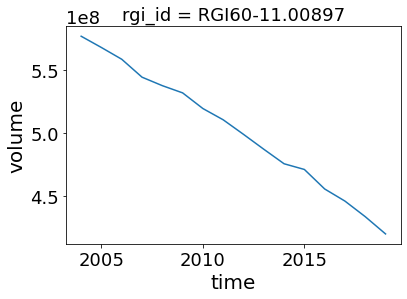

In [116]:

y0=2004
ye_h = ye-1   
# inside of run_from_climate_data_TIModel the calibrated melt_f is chosen from the melt_f_file csv file, such as:
# melt_f = pd_inv_melt_f['melt_f_opt'].loc[gdir.rgi_id]
# assert np.all(pf==pd_inv_melt_f['pf'])
workflow.execute_entity_task(run_from_climate_data_TIModel, gdirs, bias=0, #will actually point to the residual, should always be zero! 
                                  mb_model_class=TIModel,
                                  min_ys=y0, ye=ye_h,
                                  mb_type=mb_type,
                                  grad_type=grad_type,
                                  precipitation_factor=pf, 
                                  melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                                  climate_input_filesuffix=climate_type,
                                  output_filesuffix='_{}_{}_{}'.format(climate_type, mb_type, grad_type) # can add here more options to distinguish between runs
                                 )
ds_vol = utils.compile_run_output(gdirs, input_filesuffix='_{}_{}_{}'.format(climate_type, mb_type, grad_type))
ds_vol.sel(rgi_id=df[-1]).volume.plot()
# without hydro here

### similar to hydro_tutorial, but values for HEF are quite different????, 
- https://oggm.org/tutorials/stable/notebooks/hydrological_output.html
    - maybe need to check other prcp-fac
    - could also come from different initialisation! (in the tutorial, default a-factor was used, so different starting volume used here ...)
    

In [123]:
# ds = ds_runoff.sel(rgi_id=df[-1])
workflow.execute_entity_task(tasks.run_with_hydro, gdirs,
                             run_task=run_random_climate_TIModel,
                             store_monthly_hydro=True,
                             nyears=100,
                             temperature_bias=0,
                             y0=2014, # if WFDE5_CRU need to set y0=2013 because no data for 2019
                             halfsize=5, seed=0, 
                             unique_samples=True,
                             store_monthly_step=False,
                             mb_elev_feedback='annual',
                             output_filesuffix='_random_spinup_test',
                             bias=0,  # only tested with bias=0 !!!, don't change!
                             mb_type=mb_type,
                             grad_type=grad_type,
                             precipitation_factor=pf, 
                             melt_f='from_json', #melt_f_file=melt_f_file, # need to set these to find the right calibrated melt_f
                             climate_input_filesuffix=climate_type,
                             )
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_random_spinup_test')
#could also use with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
# but the method above aggregates all glaciers

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()


2021-07-01 10:51:39: oggm.workflow: Execute entity task run_with_hydro on 2 glaciers
2021-07-01 10:51:40: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-07-01 10:51:40: oggm.utils: Applying compile_run_output on 2 gdirs.


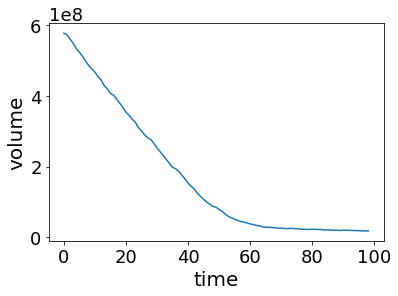

In [124]:
ds.volume.plot()
# the glacier will be almost gone in that climate 

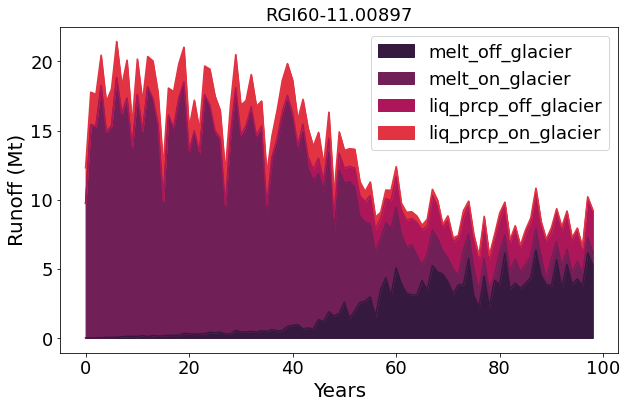

In [125]:
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); #, stacked=False
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(gdir.rgi_id);


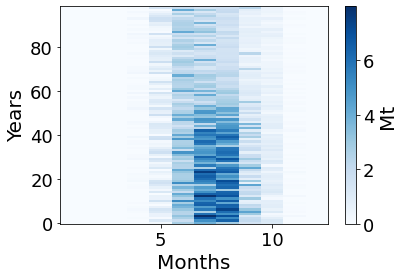

In [126]:
ds_roll = ds.roll(month_2d=ds['calendar_month_2d'].data[0]-1, roll_coords=True)
ds_roll['month_2d'] = ds_roll['calendar_month_2d']

# Select only the runoff variables and convert them to megatonnes (instead of kg)
monthly_runoff = ds_roll['melt_off_glacier_monthly'] + ds_roll['melt_on_glacier_monthly'] + ds_roll['liq_prcp_off_glacier_monthly'] + ds_roll['liq_prcp_on_glacier_monthly'] 
monthly_runoff *= 1e-9
monthly_runoff.clip(0).plot(cmap='Blues', cbar_kwargs={'label':'Mt'}); plt.xlabel('Months'); plt.ylabel('Years');

In [127]:
# Pick the variables we need (the 2d ones)
sel_vars = [v for v in ds_roll.variables if 'month_2d' in ds_roll[v].dims]

# Pick the first decade and average it
df_m_s = ds_roll[sel_vars].isel(time=slice(0, 10)).mean(dim='time').to_dataframe() * 1e-9
# Rename the columns for readability
df_m_s.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
# Because of floating point precision sometimes runoff can be slightly below zero, clip
df_m_s = df_m_s.clip(0)

# Same for end
df_m_e = ds_roll[sel_vars].isel(time=slice(-11, -1)).mean(dim='time').to_dataframe() * 1e-9
df_m_e.columns = [c.replace('_monthly', '') for c in df_m_s.columns]
df_m_e = df_m_e.clip(0)


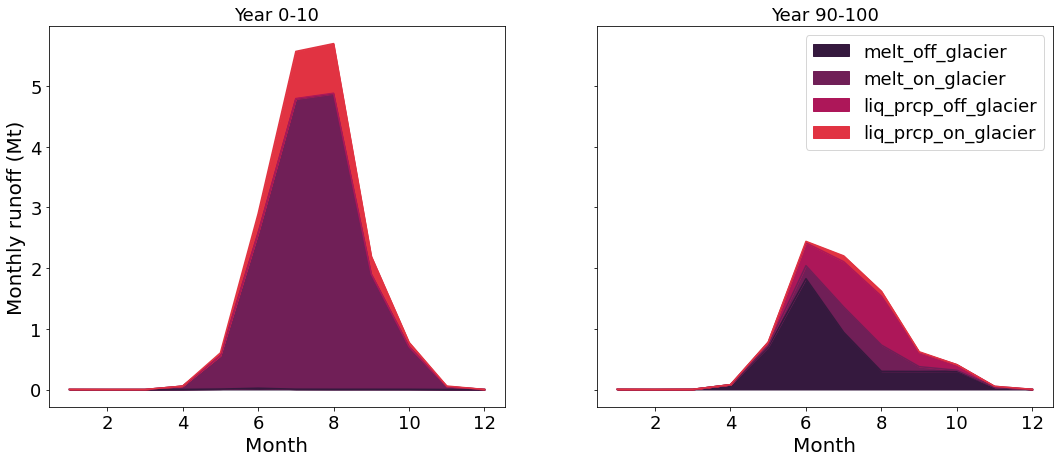

In [128]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7), sharey=True);
df_m_s[runoff_vars].plot.area(ax=ax1, legend=False, title='Year 0-10', color=sns.color_palette("rocket"));
df_m_e[runoff_vars].plot.area(ax=ax2, title='Year 90-100', color=sns.color_palette("rocket"));
ax1.set_ylabel('Monthly runoff (Mt)'); ax1.set_xlabel('Month'); ax2.set_xlabel('Month');

# now do the workflow of Sarah: 
- repeat the spinup again:
    - I use here a smaller halfsize and add a negative temperature bias

In [129]:
temp_bias = -1 
# temp_bias for W5E5_MSWEP (with MSWEP prcp, and prcp-fac of 1) needs to be higher than for W5E5 (with prcp-fac of 2)
# you can change this and see how it influences the glacier volume

In [130]:
workflow.execute_entity_task(tasks.run_with_hydro, gdirs, 
                             run_task=run_random_climate_TIModel,
                        store_monthly_hydro=True,
                        nyears=500,
                        y0=1984, halfsize=5,
                        seed=0, 
                        temperature_bias=temp_bias,
                        unique_samples=True,
                        store_monthly_step=False,
                        mb_elev_feedback='annual',
                        output_filesuffix='_random_spinup',
                        bias=0,  # only tested with bias=0 !!!, don't change!
                        mb_type=mb_type,
                        grad_type=grad_type,
                        precipitation_factor=pf, melt_f='from_json',
                        climate_input_filesuffix=climate_type,
                        )

2021-07-01 10:51:43: oggm.workflow: Execute entity task run_with_hydro on 2 glaciers


[None, None]

2021-07-01 10:51:49: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-07-01 10:51:49: oggm.utils: Applying compile_run_output on 2 gdirs.


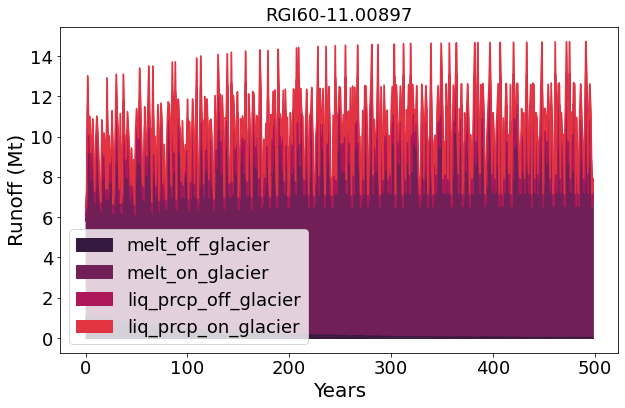

In [131]:

with xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_random_spinup')) as ds:
    # The last step of hydrological output is NaN (we can't compute it for this year)
    ds = ds.isel(time=slice(0, -1)).load()
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_random_spinup')

# The last step of hydrological output is NaN (we can't compute it for this year)
ds= ds_runoff.sel(rgi_id=df[-1]).isel(time=slice(0, -1)).load()
ds = ds.drop_vars('rgi_id')
ds = ds.isel(time=slice(0, -1)).load()


sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); #, stacked=False
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(gdir.rgi_id);


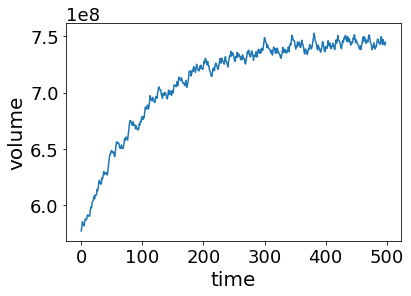

In [132]:
ds.volume.plot()
# the glacier will be almost gone if no temp_bias
# want that glacier volume is higher than the inversion volume (at point 0)

# run the climate 

2021-07-01 10:51:50: oggm.workflow: Execute entity task run_with_hydro on 2 glaciers
2021-07-01 10:51:50: oggm.utils: Applying global task compile_run_output on 2 glaciers
2021-07-01 10:51:50: oggm.utils: Applying compile_run_output on 2 gdirs.


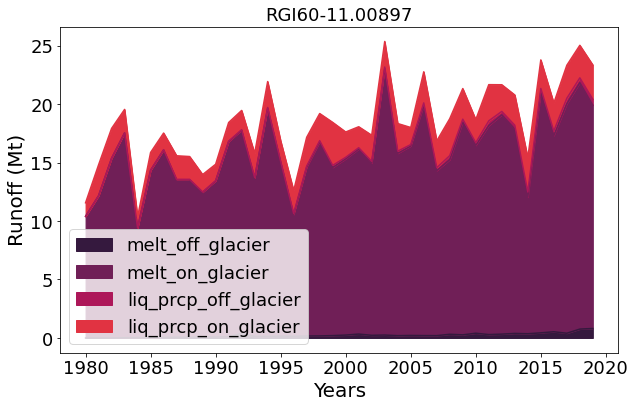

In [133]:
workflow.execute_entity_task(tasks.run_with_hydro, gdirs, 
                             run_task=run_from_climate_data_TIModel, store_monthly_hydro = True,
                    ys=1980, ye=ye,
                    init_model_filesuffix='_random_spinup', # if you want to apply the spinup need to add here the right filesuffix !!!!!!!!!!!!!!!!
                    store_monthly_step= False,
                    output_filesuffix='_1980_{}_{}_{}'.format(ye, mb_type, grad_type),
                    # kwargs for TIModel 
                     mb_model_class=TIModel,
                     bias=0, # only tested with bias=0 !!!, don't change!
                     mb_type=mb_type,
                     grad_type=grad_type,
                     precipitation_factor=pf, melt_f='from_json',
                     climate_input_filesuffix=climate_type,
                    )
ds_runoff = utils.compile_run_output(gdirs, input_filesuffix='_1980_{}_{}_{}'.format(ye, mb_type, grad_type))

# only select HEF   
ds = ds_runoff.sel(rgi_id = df[-1])
ds = ds.drop_vars('rgi_id')

# The last step of hydrological output is NaN (we can't compute it for this year)
ds = ds.isel(time=slice(0, -1)).load()
sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
df_annual = ds[sel_vars].to_dataframe()
# Select only the runoff variables and convert them to megatonnes (instead of kg)
runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
df_runoff = df_annual[runoff_vars] * 1e-9

f, ax = plt.subplots(figsize=(10, 6));
df_runoff.plot.area(ax=ax, color=sns.color_palette("rocket")); #, stacked=False
plt.xlabel('Years'); plt.ylabel('Runoff (Mt)'); plt.title(gdir.rgi_id);


- does this make sense that runoff rather increases, because peak water has been reached at some time between 2010 and 2020 ??? 

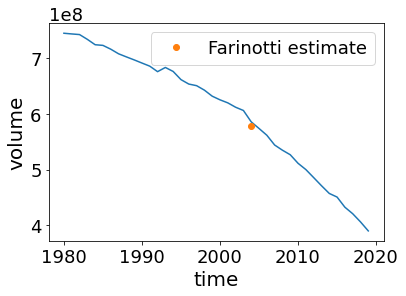

In [134]:
ds.volume.plot()
ds.sel(time=2004).volume
# volume estimate of Farinotti 
plt.plot(2004, pd_inv_melt_f.loc[gdir.rgi_id].vol_itmix_m3, 'o', label='Farinotti estimate')
plt.legend()

- depending on which prcp-fac, the spin-up is not sufficient and we could apply a negative temp. bias because initial volume in 1980 should be well above the rgi_date,
    - need to find a valid temp_bias that results in the right volume in 2004 (this depends on prcp_fac, mb_type, grad_type)
        - e.g. if W5E5, prcp_fac =2, mb_type = 'mb_real_daily', and grad_type = 'var_an_cycle' -> temp_bias during spin up needs to be at around -0.7°C
        - but if WFDE5_CRU, prcp_fac=1, rest the same -> temp_bias around -0.4°C

# some precipitation analysis

In [135]:
# extract directly the climate data (depends on climate_type)
clim = xr.open_dataset(gdir.get_filepath('climate_historical', filesuffix='_daily_{}'.format(climate_type)))
clim.prcp

<xarray.DataArray 'prcp' (time: 14975)>
array([0.0625, 0.6875, 3.1875, ..., 0.    , 0.    , 0.    ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Attributes:
    units:      kg m-2
    long_name:  total daily precipitation amount, 1979-01-01 prcp assumed to ...

In [25]:
from MBsandbox.mbmod_daily_oneflowline import get_w5e5_file
lon, lat = (10.7584, 46.8003)

wfde5_pr = xr.open_dataset(get_w5e5_file(dataset='WFDE5_CRU_daily', var='prcp'))# .tp
c = (wfde5_pr.longitude - lon)**2 + (wfde5_pr.latitude - lat)**2
wfde5_pr = wfde5_pr.isel(points=c.argmin()).tp
# based on CRU

from oggm.cfg import SEC_IN_YEAR, SEC_IN_MONTH, SEC_IN_DAY
w5e5_pr = xr.open_dataset(get_w5e5_file(dataset='W5E5_daily', var='prcp')) #.pr
c = (w5e5_pr.longitude - lon)**2 + (w5e5_pr.latitude - lat)**2
w5e5_pr = w5e5_pr.isel(points=c.argmin()).sel(time=slice('1979', '2018')).pr *SEC_IN_DAY
# based on GPCC prcp correction!!! 

2021-06-14 11:23:50: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/wfde5_cru/daily/v1.1/wfde5_cru_prcp_1979-2018_flat.nc


In [26]:
clim # note that the lon_pr and lat_pr is different to the one for temp and for the gradient
# also the ref_hgt is only true for the temp/gradient part and not for the prcp time series (as other gridpoint!!!)

<xarray.Dataset>
Dimensions:   (time: 14975)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    prcp      (time) float32 0.0625 0.6875 3.188 0.0 0.0 ... 1.0 0.0 0.0 0.0 0.0
    temp      (time) float32 ...
    gradient  (time) float32 ...
Attributes:
    ref_hgt:         2252.0
    ref_pix_lon:     10.75
    ref_pix_lat:     46.75
    ref_pix_dis:     5629.566753389074
    ref_pix_lon_pr:  10.75
    ref_pix_lat_pr:  46.85
    climate_source:  temp: W5E5_daily, prcp: MSWEP_daily, lapse rate: ERA5dr
    hydro_yr_0:      1979
    hydro_yr_1:      2019
    author:          OGGM
    author_info:     Open Global Glacier Model

In [137]:
from oggm.cfg import SEC_IN_YEAR, SEC_IN_MONTH, SEC_IN_DAY
from MBsandbox.mbmod_daily_oneflowline import get_w5e5_file
lon, lat = (10.7584, 46.8003)

wfde5_pr_all = xr.open_dataset(get_w5e5_file(dataset='WFDE5_CRU_daily', var='prcp'))# .tp
c = (wfde5_pr_all.longitude - lon)**2 + (wfde5_pr_all.latitude - lat)**2
lat_wfde5, lon_wfde5 = (wfde5_pr_all.isel(points=c.argmin()).latitude, wfde5_pr_all.isel(points=c.argmin()).longitude)
wfde5_pr = wfde5_pr_all.isel(points=c.argmin()).sel(time=slice('1980', '2018')).tp # this is already in mm 
# based on CRU

w5e5_pr_all = xr.open_dataset(get_w5e5_file(dataset='W5E5_daily', var='prcp')) #.pr
c = (w5e5_pr_all.longitude - lon)**2 + (w5e5_pr_all.latitude - lat)**2
lat_w5e5, lon_w5e5 = (w5e5_pr_all.isel(points=c.argmin()).latitude, w5e5_pr_all.isel(points=c.argmin()).longitude)
w5e5_pr = w5e5_pr_all.isel(points=c.argmin()).sel(time=slice('1980', '2018')).pr *SEC_IN_DAY
# based on GPCC prcp correction!!! 

w5e5_mswep_pr_all = xr.open_dataset(get_w5e5_file(dataset='MSWEP_daily', var='prcp')) #.pr
c = (w5e5_mswep_pr_all.longitude - lon)**2 + (w5e5_mswep_pr_all.latitude - lat)**2
lat_w5e5_mswep, lon_w5e5_mswep = (w5e5_mswep_pr_all.isel(points=c.argmin()).latitude, w5e5_mswep_pr_all.isel(points=c.argmin()).longitude)
w5e5_mswep_pr = w5e5_mswep_pr_all.isel(points=c.argmin()).sel(time=slice('1980', '2018')).pr *SEC_IN_DAY
# based on mswep prcp

# choosing wfde5/w5e5 gridpoint:
w5e5_mswep_pr_wfde5_gp = xr.open_dataset(get_w5e5_file(dataset='MSWEP_daily', var='prcp')) #.pr
c = (w5e5_mswep_pr_wfde5_gp.longitude - lon_wfde5)**2 + (w5e5_mswep_pr_wfde5_gp.latitude - lat_wfde5)**2
w5e5_mswep_pr_wfde5_gp = w5e5_mswep_pr_wfde5_gp.isel(points=c.argmin()).sel(time=slice('1980', '2018')).pr *SEC_IN_DAY


In [138]:
day_in_m= wfde5_pr.resample({'time':'MS'}).mean().time.dt.days_in_month[:12].values

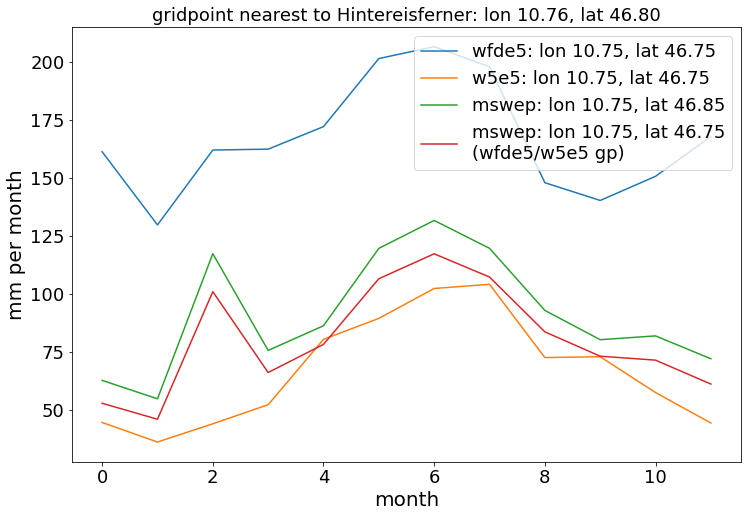

In [139]:
plt.figure(figsize=(12,8))
plt.plot(wfde5_pr.groupby('time.month').mean()*day_in_m, label='wfde5: lon {:0.2f}, lat {:0.2f}'.format(lon_wfde5.values, lat_wfde5.values))
plt.plot(w5e5_pr.groupby('time.month').mean()*day_in_m, label='w5e5: lon {:0.2f}, lat {:0.2f}'.format(lon_w5e5.values, lat_w5e5.values))
plt.plot(w5e5_mswep_pr.groupby('time.month').mean()*day_in_m, label='mswep: lon {:0.2f}, lat {:0.2f}'.format(lon_w5e5_mswep.values,
                                                                                                             lat_w5e5_mswep.values))
plt.plot(w5e5_mswep_pr_wfde5_gp.groupby('time.month').mean()*day_in_m, label='mswep: lon {:0.2f}, lat {:0.2f}\n(wfde5/w5e5 gp)'.format(lon_wfde5.values,
                                                                                                             lat_wfde5.values))
plt.legend()
plt.ylabel('mm per month')
plt.xlabel('month')
plt.title('gridpoint nearest to Hintereisferner: lon {:0.2f}, lat {:0.2f}'.format(lon, lat))
plt.savefig('hef_wfde5_w5e5_mswep_comparison.png')

In [140]:
wfde5_pr

<xarray.DataArray 'tp' (time: 14245)>
array([ 1.767979,  9.603451,  8.084311, ...,  0.      ,  8.447729, 15.180242],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2018-12-31
Attributes:
    units:        kg m-2 day-1 ~ mm/day
    long_name:    total daily precipitation (rainfall+snowfall)
    coordinates:  longitude latitude time_

In [28]:
w5e5_pr.mean() / wfde5_pr.mean() 
#ratio of w5e5 to wfde5, that means GPCC versus CRU??? 

<xarray.DataArray ()>
array(0.40103577)

In [142]:
utils.corrcoef(w5e5_pr.values, wfde5_pr.values)

0.9156916374311431

In [143]:
w5e5_mswep_pr.mean() / wfde5_pr.mean() 


<xarray.DataArray ()>
array(0.54797433)

In [47]:
utils.corrcoef(w5e5_mswep_pr.values, wfde5_pr.values)

0.63322883033617

- need possibly higher prcp-fac for W5E5 and W5E5_MSWEP than for WFDE5_CRU in case of HEF! How is it for the Rhine basin or total Alps?